In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [9]:
import statsmodels.api as sm

In [3]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_clean.csv', index_col="time")


In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
def prep_split(df, columns_drop, label, train_end_date, hours_ahead):
    # Add a column with the label shifted by "hours" rows

    if hours_ahead == 0:
        df['label_shifted'] = df[label]
    else:
        df['label_shifted'] = df[label].shift(-hours_ahead)
        # Drop the last "hours" rows as they have no label values
        df = df.iloc[:-hours_ahead]
   
    
    def split_by_date(X, train_end_date):
        if not isinstance(train_end_date, pd.Timestamp):
            train_end_date = pd.Timestamp(train_end_date)

        # Convert index of X and y to Timestamp objects if they are strings
        if isinstance(X.index[0], str):
            X.index = pd.to_datetime(X.index)

        X_train = X[X.index <= train_end_date]
        X_test = X[X.index > train_end_date]

        return X_train, X_test

    X = df.drop(columns=columns_drop + ['label_shifted'])
    y = df['label_shifted']

    X_train, X_test = split_by_date(X, train_end_date)
    y_train, y_test = split_by_date(y, train_end_date)

    # Standardize all columns except target
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = prep_split(df, 
                                               columns_drop=[], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [10]:
# SARIMAX Model
model = sm.tsa.statespace.SARIMAX(y_train, 
                exog=X_train, 
                order=(1, 0, 1), 
                seasonal_order=(1, 0, 1, 12),  # Assuming monthly data with yearly seasonality
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          127     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66728D+00    |proj g|=  4.63447D-01


 This problem is unconstrained.



At iterate    5    f=  2.62135D+00    |proj g|=  3.45424D-01

At iterate   10    f=  2.57520D+00    |proj g|=  1.50680D+00

At iterate   15    f=  2.57078D+00    |proj g|=  1.00730D+00

At iterate   20    f=  2.55292D+00    |proj g|=  3.93420D-01

At iterate   25    f=  2.54611D+00    |proj g|=  1.93477D-01

At iterate   30    f=  2.53965D+00    |proj g|=  1.14537D+00

At iterate   35    f=  2.52480D+00    |proj g|=  8.15845D-01

At iterate   40    f=  2.52474D+00    |proj g|=  3.95578D-02

At iterate   45    f=  2.52268D+00    |proj g|=  2.47040D+00

At iterate   50    f=  2.50729D+00    |proj g|=  6.60355D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

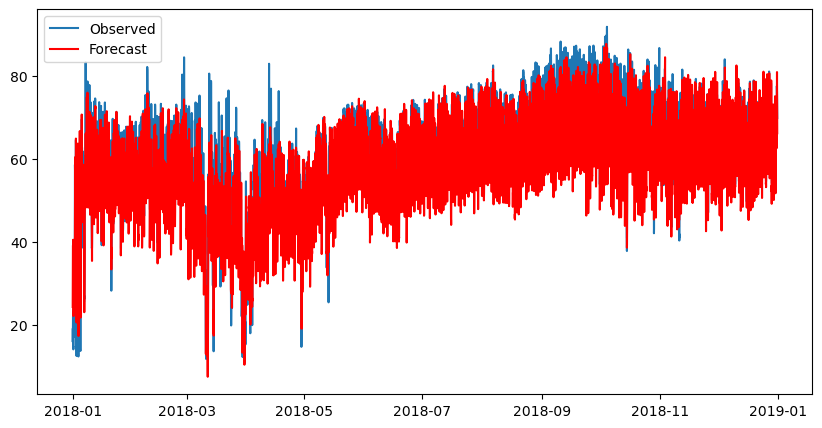

In [11]:
# Forecast
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
mean_forecast = forecast.predicted_mean

# Compare forecasted data with actual data
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Observed')
plt.plot(y_test.index, mean_forecast, label='Forecast', color='r')
plt.legend()
plt.show()

In [12]:
mse = mean_squared_error(y_test, mean_forecast)
mae = mean_absolute_error(y_test, mean_forecast)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 56.19713269992326
MAE: 6.09867464875387
